In [1]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter


import torch.nn as nn
import torch.optim as optim

device='cuda'

torch.manual_seed(212121)

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import pandas as pd
import seaborn as sns

In [3]:
# define resnet model
class MobileNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)  # update final layer

    def forward(self, x):
        return self.mobilenet(x)
    
def train_model(model, dataloader, epochs=5, scale=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    best_loss = np.inf
    best_state = None 
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()  # save the best so far! ⭐
            stale_epochs = 0
        else:
            stale_epochs += 1
            if stale_epochs >= 10:
                print("early stopping! no improvement :(")
                break

    if best_state is not None:
        model.load_state_dict(best_state)  # restore the champ! 🏆

    return model  # all done!


def gaussian_noise(images, scale):
    return np.random.normal(size=images.shape)*scale + images

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs

def resample_one_v_all(true_labels, target_label):
    target_indices = []
    other_indices = []
    for i, label in enumerate(true_labels):
        if target_label == label:
            target_indices.append(i)
        else:
            other_indices.append(i)

    other_indices = np.random.choice(other_indices, len(target_indices), replace=False)
    indices = np.concatenate([target_indices, other_indices])
    return indices.astype(int)


def estimate_mi_repr(model, dataloader, scale=0):
    model.eval()
    true_labels = []
    last_layer_reprs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            last_layer_reprs.append(outputs.cpu().numpy())

    true_labels = np.concatenate(true_labels)
    last_layer_reprs = np.concatenate(last_layer_reprs)

    MIs = []
    N_samples = []
    labels = []

    for label in np.unique(true_labels):
        N_samples.append(np.sum(true_labels == label))
        labels.append(label)
        idx = resample_one_v_all(true_labels, label)
        bin_y = true_labels[idx] == label
        reprs = last_layer_reprs[idx]
        
        MIs.append(np.nanmean(lmi.estimate(bin_y.reshape(-1, 1), reprs)[0]))

    # all labels → one-hot!
    uniques = np.unique(true_labels).tolist()
    n_classes = len(uniques)
    one_hot_labels = np.eye(n_classes)[[uniques.index(s) for s in true_labels]]
    MIs.append(np.nanmean(lmi.estimate(one_hot_labels, last_layer_reprs, N_dims=16)[0]))
    N_samples.append(len(true_labels))
    labels.append('all')

    print(MIs)

    return MIs, N_samples, labels


In [4]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((240, 240)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

# load dataset
Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)

# get class labels
labels = Caltech101.y  # class indices for the dataset

# count occurrences of each class
class_counts = Counter(labels)

# find top n largest classes
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]

# subset the dataset to include only samples from these top classes
indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

# split the subset into train and validation sets
N = len(subset)
print(f"{N} total samples")
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])

# create data loaders
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

Files already downloaded and verified
2707 total samples


In [5]:
d = {
    "Scale" : [],
    "MI" : [],
    "Class label" : [],
    "N instances of label" : []
}

MIs = []
scales = np.logspace(-1, 2, 10)

# process each factor
for scale in scales:

    model = MobileNetClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=5, scale=scale)

    # estimate mutual info
    mi, n_inst, labels = estimate_mi_repr(model, val_loader, scale=scale)
    d['MI'] += mi
    d['Scale'] += [scale] * len(mi)
    d['Class label'] += labels
    d["N instances of label"] += n_inst

/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.0698
Epoch 2/5, Loss: 0.5560
Epoch 3/5, Loss: 0.0867
Epoch 4/5, Loss: 0.0356
Epoch 5/5, Loss: 0.0196
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.997982104207601, 0.9758583383290675, 1.0001881778888349, 0.9906497079802544, 0.9532426709341056, 2.168225963590958]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.0303
Epoch 2/5, Loss: 0.5879
Epoch 3/5, Loss: 0.0987
Epoch 4/5, Loss: 0.0378
Epoch 5/5, Loss: 0.0210
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.967076995155896, 0.978608982054719, 1.0017877234518364, 0.9975035592375887, 1.0060362752563834, 2.1702835459006566]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.1425
Epoch 2/5, Loss: 0.6398
Epoch 3/5, Loss: 0.1245
Epoch 4/5, Loss: 0.0564
Epoch 5/5, Loss: 0.0366
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9540005678238905, 0.981101646051389, 0.9966198403903066, 1.0017359698194872, 1.00481342196108, 2.1627617160018993]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.2196
Epoch 2/5, Loss: 0.9909
Epoch 3/5, Loss: 0.3004
Epoch 4/5, Loss: 0.1331
Epoch 5/5, Loss: 0.0737
epoch 219 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9778343290049397, 0.9588695311753563, 0.9844418500463226, 0.9575246050111134, 0.9974785841148878, 2.137217287893242]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.5972
Epoch 2/5, Loss: 1.4713
Epoch 3/5, Loss: 0.6113
Epoch 4/5, Loss: 0.3392
Epoch 5/5, Loss: 0.2414
epoch 148 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9201880875439115, 0.8682702740919112, 0.9071697833488728, 0.8614034600308395, 0.8024197865723149, 2.0355750475829373]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.7637
Epoch 2/5, Loss: 2.0007
Epoch 3/5, Loss: 1.1096
Epoch 4/5, Loss: 0.7561
Epoch 5/5, Loss: 0.5659
epoch 277 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.5869544572854659, 0.6962219517698499, 0.7198083471871343, 0.7482659272843546, 0.5484510363948104, 1.5662391539329081]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.1115
Epoch 2/5, Loss: 2.6807
Epoch 3/5, Loss: 1.6608
Epoch 4/5, Loss: 1.2001
Epoch 5/5, Loss: 0.9893
epoch 139 (of max 300) 🌻🌻🌻🌻[0.3384070823969878, 0.35797287972740577, 0.6548329190199697, 0.38850813116263916, 0.272357671213676, 0.9674308273723115]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.0645
Epoch 2/5, Loss: 2.8340
Epoch 3/5, Loss: 1.9997
Epoch 4/5, Loss: 1.5476
Epoch 5/5, Loss: 1.3512
epoch 102 (of max 300) 🌻🌻🌻🌻🌻[0.19141310129485217, 0.15228477250056915, 0.3838898637310455, 0.08472593742046579, 0.040311033982775815, 0.46642967292306825]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.9977
Epoch 2/5, Loss: 2.8343
Epoch 3/5, Loss: 2.1006
Epoch 4/5, Loss: 1.7902
Epoch 5/5, Loss: 1.6469
epoch 107 (of max 300) 🌻🌻🌻[0.051946394339030866, -0.07416748445362586, 0.06847278073321102, -0.00022802191476294559, 0.06967874089983891, 0.019617741010681027]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.0368
Epoch 2/5, Loss: 2.8692
Epoch 3/5, Loss: 2.1464
Epoch 4/5, Loss: 1.8105
Epoch 5/5, Loss: 1.6936
epoch 119 (of max 300) 🌻🌻🌻[-0.05796412322827137, -0.00593219906332231, -0.005268868836215581, 0.05588820947271129, -0.00739692457708479, 0.03947495698998872]


In [6]:
df = pd.DataFrame(data=d)
df.to_csv('../results/Caltech101_lastlayer.csv')

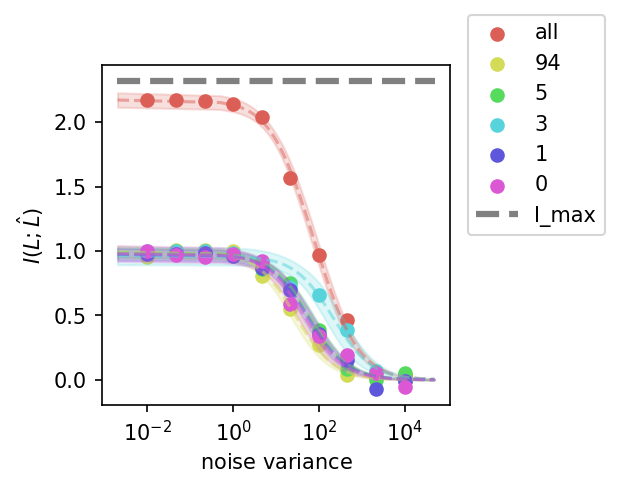

In [7]:
from lmfit import Model

def info_scaling(x, A, B):
    return 0.5 * np.log2(((1/x)*B+ 1)/(1+A*(1/x)))

fig = plt.figure(figsize=(3,3), dpi=150)


classes = df[df['N instances of label'] > 100]['Class label'].unique()
palette = sns.color_palette("hls", len(classes))

for i, x in enumerate(classes[::-1]):
    # prepare data
    x_data = df[df['Class label'] == x]['Scale']**2
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    # generate fit line
    x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
    y_lower = -y_upper

    # plot fit and data
    plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[i], alpha=0.2)
    plt.scatter(x_data, y_data, color=palette[i], label=x)

I_max = np.log2(top_n)
plt.plot([np.min(x_fit), np.max(x_fit)], [I_max, I_max], linestyle='--', 
         color='grey', label='I_max', lw=3)


plt.xlabel(r'$\text{noise variance}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.xscale('log')
plt.legend(loc=(1.05, 0.5))